<a href="https://colab.research.google.com/github/TheRoberto2512/DeepBrainMRI/blob/main/Modello_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**SOMMARIO DEL NOTEBOOK**</font>

In questo notebook si testerà la massima efficacia che può ottenere un modello Dense, nonostante esso non sia adatto a questo tipo di task. Per maggiori informazioni riguardo le scelte intraprese fare riferimento al report finale.


**Indice:**
*   [Installazioni, import librerie e funzioni utili](#1)
*   [Caricamento del Dataset](#2)
*   [Modello Dense](#3)
*   [Risultati dell'addestramento](#4)
*   [Modello Finale](#5)



<a name="1"></a>
# Installazioni, import librerie e funzioni utili

In [ ]:
! pip install tensorflow-gpu==2.8.3

In [ ]:
from sklearn.metrics import confusion_matrix
from google.colab import drive, files
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd                                                               # per gestire la serializzazione/deserializzazione dei risultati
import numpy as np
import shutil                                                                     # per fare spostamenti e copie tra drive e colab
import os                                                                         # per gestire le cartelle dei dataset

In [ ]:
drive.mount("/content/drive", force_remount=True)                                 # montiamo il drive per prelevare i dataset

Mounted at /content/drive


In [ ]:
#@title Qualora la cartella principale del progetto non si trovi nella home di Google Drive, personalizzare la seguente stringa:

main_folder_path = '/content/drive/MyDrive/DeepBrainMRI' #@param {type:"string"}

Le seguenti funzioni servono per salvare/caricare facilmente le history, le evaluation e i pesi del modello su Google Drive.

In [ ]:
result_folder_path = f"{main_folder_path}/Risultati vari/Dense"
saved_weights_path = f"{main_folder_path}/Saved Weights/Dense"
dataset_directory = ''

def saveHistory(history, nomeFile):                                               # funzione per salvare la history di un addestramento
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  history_df = pd.DataFrame.from_dict(history.history)
  history_df.to_csv(result_folder_path + f"/{dataset_directory}_{nomeFile}_history.csv", index=False)

def loadHistory(nomeFile):                                                        # funzione per caricare la history di un addestramento
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{nomeFile}_history.csv").to_dict()
  else:
    raise Exception("Cartella inesistente!")

def saveEvaluation(loss, acc, f1, nomeFile):                                      # funzione per salvare il risultato di un evaluation
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  evaluation = {}
  evaluation['loss'] = loss
  evaluation['accuracy'] = acc
  evaluation['f1_score'] = f1
  evaluation_df = pd.DataFrame.from_dict(evaluation)
  evaluation_df.to_csv(result_folder_path + f"/{dataset_directory}_{nomeFile}_evaluation.csv", index=False)

def loadEvaluation(nomeFile):                                                     # funzione per caricare il risultato di un evaluation
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{nomeFile}_evaluation.csv").to_dict()
  else:
    raise Exception("Cartella inesistente!")

def saveWeights(nomeFile):                                                        # funzione per salvare il file dei pesi su drive
  if not os.path.exists(saved_weights_path):
    os.makedirs(saved_weights_path)
  shutil.copy(nomeFile, f"{saved_weights_path}")

def loadWeights(nomeFile):                                                        # funzione per caricare il file dei pesi da drive
  if os.path.exists(saved_weights_path):
    shutil.copy(f"{saved_weights_path}/{nomeFile}", '/content/')
  else:
    raise Exception("Cartella inesistente!")

<a name="2"></a>
# Caricamento del Dataset


In [ ]:
#@title Impostiamo dei valori costanti per la corretta esecuzione del notebook.
base_datasets_path = f"{main_folder_path}/Datasets/"

BATCH_SIZE = 32 #@param {type: "integer"}                       # specifichiamo la grandezza dei batch
IMAGE_WIDTH = 299 #@param {type: "integer"}
IMAGE_HEIGHT = 299 #@param {type: "integer"}

IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)                    # c'è solamente un canale perché importiamo in scala di grigi

SEED = 2680 #@param {type: "integer"}                           # seme per poter replicare le stesse condizioni del dataset

Sceliere il tipo di dataset (train_data) che si vuole importare:

In [ ]:
dataset_directory = 'under+aug'                                 # dataset con undersampling e data augmentation

In [ ]:
dataset_directory = 'only_under'                                # dataset con SOLO undersampling

In [ ]:
dataset_directory = 'only_aug'                                  # dataset con solo data augmentation

In [ ]:
dataset_directory = 'base'                                      # dataset base (non pre-processato)

Istruzioni per importare il dataset. **Sono richiesti fino a 2-3 minuti a seconda del dataset!**

In [ ]:
destinazione = f"/content/dataset/{dataset_directory}"

if dataset_directory != 'base':
  shutil.copytree(f'{base_datasets_path}{dataset_directory}', f'{destinazione}/Training', dirs_exist_ok=True)     # train_data pre-processato
else:
  shutil.copytree(f'{base_datasets_path}DATASET_BASE/Training', f'{destinazione}/Training', dirs_exist_ok=True)   # train_data base
print(f"Ho importato il training set \'{dataset_directory}\' nella cartella {destinazione}/Training")

shutil.copytree(f'{base_datasets_path}DATASET_BASE/Testing', f'{destinazione}/Testing', dirs_exist_ok=True)       # importa il test_data
print(f"Ho importato il test set nella cartella {destinazione}/Testing")

Ho importato il training set 'base' nella cartella /content/dataset/base/Training
Ho importato il test set nella cartella /content/dataset/base/Testing


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destinazione}/Training',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destinazione}/Testing',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

class_names = test_data.class_names
print("\nHo caricato train_data e test_data dalla cartella %s" % destinazione)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.

Ho caricato train_data e test_data dalla cartella /content/dataset/base


Stampando la shape di un batch di immagini possiamo notare che corrisponderà a:

(**BATCH_SIZE**, **IMAGE_WIDTH**, **IMAGE_HEIGHT**, **1**)

In [ ]:
for img, lbl in train_data.take(1):
  print(img.shape)

(32, 299, 299, 1)


<a name="3"></a>
# Modello Dense

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')                               # '4' corrisponde al numero delle classi
])

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 89401)             0         
                                                                 
 rescaling_14 (Rescaling)    (None, 89401)             0         
                                                                 
 dense_42 (Dense)            (None, 64)                5721728   
                                                                 
 dense_43 (Dense)            (None, 16)                1040      
                                                                 
 dense_44 (Dense)            (None, 4)                 68        
                                                                 
Total params: 5722836 (21.83 MB)
Trainable params: 5722836 (21.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="Dense.keras", save_best_only=True, monitor="val_loss")  # salviamo i pesi dell'epoca con la val_loss minore
]

Permette di impostare un learning rate decay:

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.002,                                                                        # learning rate iniziale
    decay_steps=len(train_data)*13,                                               # ogni quanto si decrementa il learning rate
    decay_rate=0.66,                                                              # tasso di decremento
    staircase=True)                                                               # decrementa a intervalli discreti

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

In [ ]:
total_batches = tf.data.experimental.cardinality(train_data).numpy()              # calcola il numero totale di batch nel dataset

validation_size = int(0.2 * total_batches)                                        # imposta una percentuale per il validation set (20%)

# separa i dataset di training e validation
validation_data = train_data.take(validation_size)
train_data = train_data.skip(validation_size)

In [ ]:
epochs = 40
history = model.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks=callbacks)

Epoch 1/40
160/160 [==============================] - 7s 27ms/step - loss: 1.5046 - accuracy: 0.5690 - precision_4: 0.6242 - recall_4: 0.4316 - f1_score: 0.5694 - val_loss: 0.7495 - val_accuracy: 0.7297 - val_precision_4: 0.8522 - val_recall_4: 0.5539 - val_f1_score: 0.7183
Epoch 2/40
160/160 [==============================] - 5s 25ms/step - loss: 0.7155 - accuracy: 0.7357 - precision_4: 0.8009 - recall_4: 0.6175 - f1_score: 0.7351 - val_loss: 0.6691 - val_accuracy: 0.7445 - val_precision_4: 0.7925 - val_recall_4: 0.6477 - val_f1_score: 0.7432
Epoch 3/40
160/160 [==============================] - 5s 29ms/step - loss: 0.6241 - accuracy: 0.7688 - precision_4: 0.8152 - recall_4: 0.6884 - f1_score: 0.7683 - val_loss: 0.6776 - val_accuracy: 0.7336 - val_precision_4: 0.7692 - val_recall_4: 0.6641 - val_f1_score: 0.7366
Epoch 4/40
160/160 [==============================] - 5s 25ms/step - loss: 0.5726 - accuracy: 0.7833 - precision_4: 0.8226 - recall_4: 0.7320 - f1_score: 0.7836 - val_loss: 0.

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [ ]:
model = tf.keras.models.load_model("Dense.keras")

Se invece si volessero caricare dei pesi da Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio:")
name = input()
loadWeights(name)
model.load_weights(name)

Per valutare le performance del modello:

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_data)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

## Salvataggio dei dati

Per salvare i pesi del modello attuale su Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio:")
name = input()
model.save_weights(name)
saveWeights(name)

Qualora si voglia salvare la history in un file .csv:

In [ ]:
nome = input()
saveHistory(history, nome)

Qualora si voglia salvare l'evaluation in un file .csv:

In [ ]:
nome = input()
saveEvaluation(test_loss, test_accuracy, test_f1, nome)

<a name="4"></a>
# Risultati dell'addestramento

## History dell'addestramento appena concluso

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score = []
val_f1_score = []

epochs = range(1, len(acc) + 1)

for i in range(len(acc)):
  f1_score.append(np.mean(history.history['f1_score'][i]))
  val_f1_score.append(np.mean(history.history['val_f1_score'][i]))

## History di un addestramento passato (da caricare)

Per ricaricare una history precedente:

In [ ]:
print("Inserire il nome del file history da caricare:")
nomeFile = input()
history = loadHistory(nomeFile)

In [ ]:
acc, val_acc, loss, val_loss = [], [], [], []
for i in range(0, len(history['accuracy'])):
  acc.append(history['accuracy'][i])
  val_acc.append(history['val_accuracy'][i])
  loss.append(history['loss'][i])
  val_loss.append(history['val_loss'][i])

epochs = range(1, len(acc)+1)

f1_score, val_f1_score = [], []

for i in range(len(acc)):
  f1_score.append(np.mean([float(x) for x in history['f1_score'][i].replace('[', '').replace(']', '').split()]))
  val_f1_score.append(np.mean([float(x) for x in history['val_f1_score'][i].replace('[', '').replace(']', '').split()]))

## Plot dei risultati

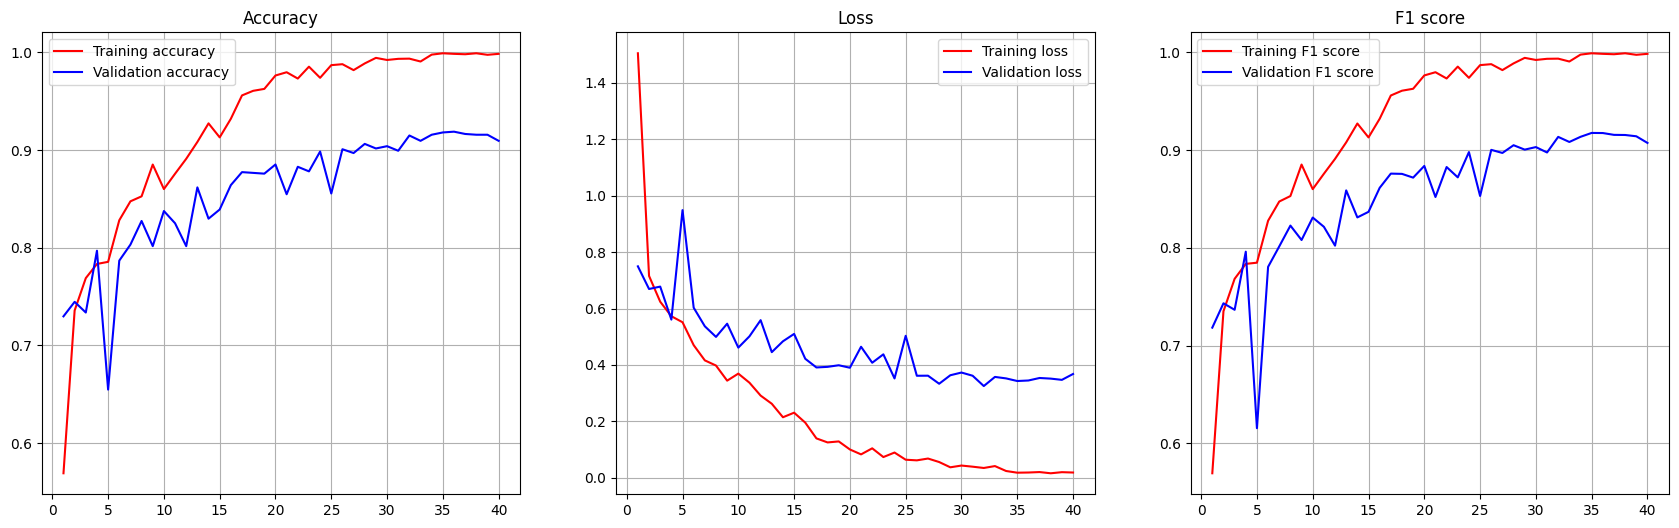

In [ ]:
# Creazione del grafico per l'accuracy
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()

# Creazione del grafico per il loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid()

# Creazione del grafico per il loss
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, 'r', label='Training F1 score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1 score')
plt.title('F1 score')
plt.legend()
plt.grid()

plt.show()

<a name="5"></a>
#Modello finale

Una volta valutati i migliori iperparametri per il modello, lo si riaddestra interamente sul training set senza nessun validation.

<font color='#c00000'>**ATTENZIONE**:</font> Ricaricare il test data se è stato splittato precedentemente per il validation!

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')                                        # '4' corrisponde al numero delle classi
])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 299, 299, 1)       0         
                                                                 
 flatten_13 (Flatten)        (None, 89401)             0         
                                                                 
 dense_39 (Dense)            (None, 64)                5721728   
                                                                 
 dense_40 (Dense)            (None, 16)                1040      
                                                                 
 dense_41 (Dense)            (None, 4)                 68        
                                                                 
Total params: 5722836 (21.83 MB)
Trainable params: 5722836 (21.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="Dense_Finale.keras", save_best_only=True, monitor="loss")  # salviamo i pesi dell'epoca con la val_loss minore
]

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.002,
    decay_steps=len(train_data)*13,
    decay_rate=0.66,
    staircase=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]) # Compila il modello

In [ ]:
epochs = 40
history = model.fit(train_data, epochs=epochs, callbacks=callbacks)

Epoch 1/40
200/200 [==============================] - 5s 18ms/step - loss: 1.3707 - accuracy: 0.5901 - precision_6: 0.6241 - recall_6: 0.5207 - f1_score: 0.5850
Epoch 2/40
200/200 [==============================] - 4s 18ms/step - loss: 0.7626 - accuracy: 0.6936 - precision_6: 0.7436 - recall_6: 0.6240 - f1_score: 0.6903
Epoch 3/40
200/200 [==============================] - 5s 25ms/step - loss: 0.6057 - accuracy: 0.7591 - precision_6: 0.7965 - recall_6: 0.7047 - f1_score: 0.7568
Epoch 4/40
200/200 [==============================] - 4s 18ms/step - loss: 0.5572 - accuracy: 0.7810 - precision_6: 0.8108 - recall_6: 0.7310 - f1_score: 0.7788
Epoch 5/40
200/200 [==============================] - 5s 24ms/step - loss: 0.4929 - accuracy: 0.8044 - precision_6: 0.8276 - recall_6: 0.7690 - f1_score: 0.8032
Epoch 6/40
200/200 [==============================] - 4s 20ms/step - loss: 0.4847 - accuracy: 0.8069 - precision_6: 0.8296 - recall_6: 0.7777 - f1_score: 0.8058
Epoch 7/40
200/200 [==============

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [ ]:
model = tf.keras.models.load_model("Dense_Finale.keras")

Se invece si volessero caricare dei pesi da Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio (deve terminare con .keras):")
name = input()
loadWeights(name)
model.load_weights(name)

Per valutare le performance del modello:

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_data)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

41/41 [==============================] - 3s 39ms/step - loss: 0.4085 - accuracy: 0.9062 - precision: 0.9081 - recall: 0.9047 - f1_score: 0.8992
Loss: 0.40846332907676697
Accuracy: 0.9061784744262695
Precision: 0.9081164002418518
Recall: 0.9046529531478882
F1-score: 0.899156928062439


##Matrice di confusione

creazione della matrice di confusione

In [ ]:
previsioni_classe = []
verita_terreno = []

# Effettuare le previsioni su ogni batch
for immagini, etichette in test_data:
    preds = model.predict(immagini, verbose=0)
    previsioni_classe.extend(np.argmax(preds, axis=1))
    verita_terreno.extend(np.argmax(etichette.numpy(), axis=1))

# Calcolare la matrice di confusione
matrice_confusione = confusion_matrix(verita_terreno, previsioni_classe)

creazione del plot della matrice di confusione

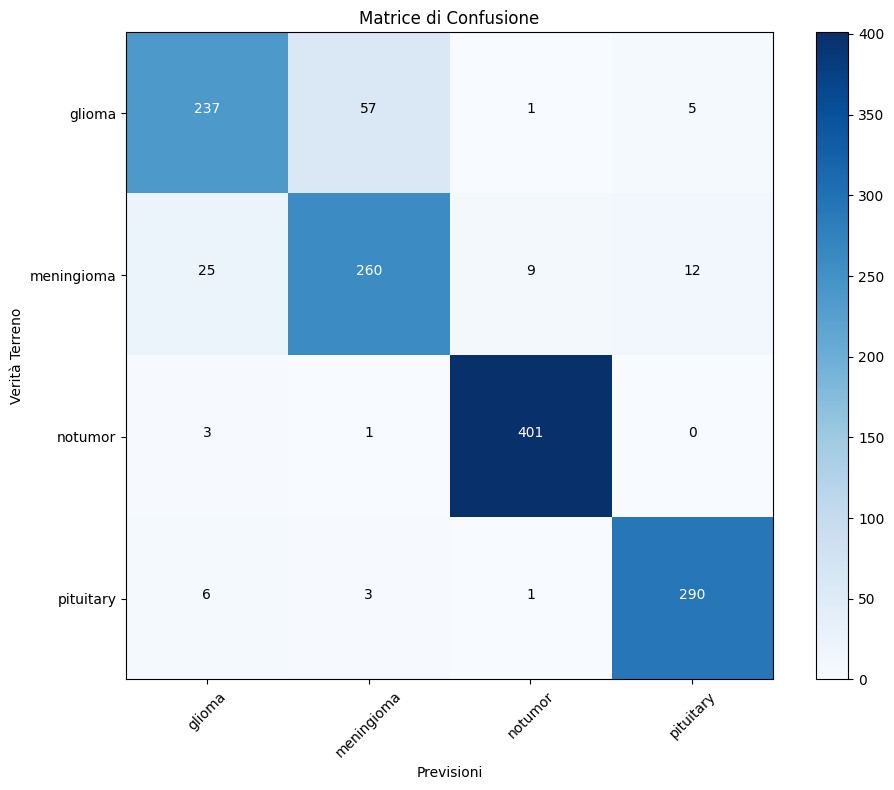

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(matrice_confusione, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.colorbar()

# Aggiungere le etichette agli assi
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Etichettare gli assi
plt.xlabel('Previsioni')
plt.ylabel('Verità Terreno')

# Mostrare i numeri all'interno delle celle
thresh = matrice_confusione.max() / 2.
for i in range(matrice_confusione.shape[0]):
    for j in range(matrice_confusione.shape[1]):
        plt.text(j, i, format(matrice_confusione[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrice_confusione[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Salvataggio dei dati

Per salvare i pesi del modello attuale su Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio (deve terminare con .keras):")
name = input()
model.save_weights(name)
saveWeights(name)

Qualora si voglia salvare la history in un file .csv:

In [ ]:
nome = input()
saveHistory(history, nome)

Qualora si voglia salvare l'evaluation in un file .csv:

In [ ]:
nome = input()
saveEvaluation(test_loss, test_accuracy, test_f1, nome)